# Police Department Incident Data of San Francisco and Chicago 
## A Project on Assesing and Comparing ML Models for two Large City Crime Datasets 
### Eren Tumkaya

In [52]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime


## About the Project

San Francisco and Chicago are two mega cities in the US, and as in any large city, crime is a significant problem that requires thorough analysis. This project will focus on exploring the relationships between selected features and incident counts in both cities. The ultimate goal is to train efficient machine learning algorithms to explain the variation in crime counts separately for both cities. Afterwards, the results will be compared.

The main datasets are from Chicago's and San Francisco's open data portals. Additionally, other datasets will be utilized to create additional features such as daily and hourly temperature, precipitation, moon status, etc. Feature engineering will be a crucial part of the project.

Exploring the data will involve utilizing exploratory machine learning models with appropriate parameters, validation techniques, and a variety of statistical tests.

## Ingesting the Datasets 

There are 7 datasets I had planned to use prior to starting this project. I will acces them all with their "API's". I will start by ingesting all of them and use them when necessary throughout the project.
 

Since both of my main datasets use similar documentations for their API's, I will write a function to be able to use in both of their ingesting. 
### Data Fetch Function

In [3]:
def fetch_dataset(url, params):
    all_data = []

    while True:
        response = requests.get(url, params=params)

        try:
            response.raise_for_status()
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            params['$offset'] += len(data)
        except requests.exceptions.HTTPError as error1:
            print(f"HTTP Error: {error1}")
            break
        except requests.exceptions.ConnectionError as error2:
            print(f"Error Connecting: {error2}")
            break
        except requests.exceptions.Timeout as error3:
            print(f"Timeout Error: {error3}")
            break
        except requests.exceptions.RequestException as error4:
            print(f"An error occurred: {error4}")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            break

    raw_dataset = pd.DataFrame(all_data)
    return raw_dataset

### San Franscisco Police Department Incident Reports: 2018 to Present

This huge dataset includes all the incident reports from 1'st of Januray, 2018 to current date. It can be found [here](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data), open data portal of San Fransciso Government. 

* This part is only for ingesting. I will perform cleaning, exploratory analysis and visualizations after I obtain all the datasets. 

In [4]:
url = "https://data.sfgov.org/resource/wg3w-h783.json"
params = {
    '$select': 'incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district',
    '$limit': 100000,
    '$offset': 0
}
SF_DATA = fetch_dataset(url, params)

In [9]:
SF_DATA.head()

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN


### Chicago Police Department Incident Reports: 2001 to Present

This dataset includes all incidents from 2001. It has more than 8 million rows. However, since I will be performing a statistical comparasion with this one and the San Franciso dataset, I will only take the data points dating after 2018 into account. Dataset can be found on [this](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/about_data) open portal of Chicago.  
* I will use the same function to ingest the data.

In [12]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
params = {
    '$select':  'date,year,description,district',
    '$limit': 100000,
    '$offset': 0
}
Chicago_Data = fetch_dataset(url, params)

In [15]:
Chicago_Data

,date,year,description,district
0,2015-03-18T12:00:00.000,2015,FINANCIAL IDENTITY THEFT OVER $ 300,001
1,2018-12-20T15:00:00.000,2018,FINANCIAL IDENTITY THEFT $300 AND UNDER,025
2,2016-05-01T00:25:00.000,2016,FINANCIAL IDENTITY THEFT OVER $ 300,008
3,2018-12-20T16:00:00.000,2018,TELEPHONE THREAT,017
4,2014-06-01T00:01:00.000,2014,FINANCIAL IDENTITY THEFT OVER $ 300,022
...,...,...,...,...
8033621,2023-04-18T08:00:00.000,2023,FINANCIAL IDENTITY THEFT $300 AND UNDER,012
8033622,2023-08-07T18:00:00.000,2023,ARMED - HANDGUN,006
8033623,2023-06-20T19:00:00.000,2023,AUTOMOBILE,010
8033624,2023-08-26T00:00:00.000,2023,TO VEHICLE,004


### Weather Condition Datasets for San Francisco
#### Temperature

I needed the hourly historical weather data for this task. I found what I was looking for in Iowa State University's Environmental Mesonet Portal. It can be found [here](https://mesonet.agron.iastate.edu/request/download.phtml?network=CA_ASOS). 
I needed to be careful on chosing the right timezone of observation. Since I want to perform modeling for the data from 2018 to current date, I only took the data for those dates.

In [25]:
SF_TEMP=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [28]:
SF_TEMP.head()

,station,valid,tmpc
0,SFO,2018-01-01 00:56,11.11
1,SFO,2018-01-01 01:56,10.56
2,SFO,2018-01-01 02:56,8.89
3,SFO,2018-01-01 03:56,8.33
4,SFO,2018-01-01 04:56,8.33


#### Precipitation

I found it on the same site. I will be ingesting the hourly precipitation data for San Francisco now.


In [29]:
SF_PREC=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [30]:
SF_PREC.head()

,station,valid,p01m
0,SFO,2018-01-01 00:56,0.00
1,SFO,2018-01-01 01:56,0.00
2,SFO,2018-01-01 02:56,0.00
3,SFO,2018-01-01 03:56,0.00
4,SFO,2018-01-01 04:56,0.00


### Weather Condition Datasets for Chicago
#### Temperature

I will change my station using the same site. I am going to pick the closest station to chicago city in order to have more reliable results both for temperature and precipitation.

In [32]:
Chicago_Temp=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")

In [34]:
Chicago_Temp.head()

,station,valid,tmpc
0,MDW,2018-01-01 00:53,-18.28
1,MDW,2018-01-01 01:53,-18.89
2,MDW,2018-01-01 02:53,-19.44
3,MDW,2018-01-01 03:53,-20.00
4,MDW,2018-01-01 04:53,-20.56


#### Precipitation


In [38]:
Chicago_Prec=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")
Chicago_Prec.head()

,station,valid,p01m
0,MDW,2018-01-01 00:53,0.00
1,MDW,2018-01-01 01:53,0.00
2,MDW,2018-01-01 02:53,0.00
3,MDW,2018-01-01 03:53,0.00
4,MDW,2018-01-01 04:53,0.00


### Full Moon Dates

[Here](https://www.healthline.com/health/full-moon-effects#full-moon-and-violence) is an interesting article about full moon effects. There have been research on whether it effects the number of ER patients. For this project, I will perform an statistical analysis on the relation of crime counts and full moons.

There were several sources which I could have ingested this data. I prefered to use Astronomical Applications Department
of the U.S. Naval Observatory site. The respected page where I found the data and the info on how to use the API can be found [here](https://aa.usno.navy.mil/data/api#phase). I am ingesting the data from 2018 to current date. 

This site gives me the whole phases of the moon. Since I will only be using "Full Moon" for this task, I included a filter in my
retrieval function.

In [44]:
def fetch_full_moon_data(start_year, end_year):
    full_moon_data = []

    for year in range(start_year, end_year + 1):
        url = f"https://aa.usno.navy.mil/api/moon/phases/year?year={year}"
        response = requests.get(url)
        phase_data = response.json()["phasedata"]
        full_moons = [phase for phase in phase_data if phase['phase'] == 'Full Moon']
        data = pd.DataFrame(full_moons)
        full_moon_data.append(data)
        
    full_moon_df = pd.concat(full_moon_data, ignore_index=True)
    return full_moon_df

start_year = 2018
end_year = 2024
full_moon_df = fetch_full_moon_data(start_year, end_year)

In [45]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


## SF Incident Data Cleaning ,EDA
### Cleaning the Dataset

Cleaning this dataset will involve turning the date formats similar to other datasets in order to easily merge them and also 

In [46]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN
...,...,...,...,...,...,...,...,...,...
839737,2023-03-22T13:30:00.000,2023-03-22T00:00:00.000,13:30,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9
839738,2023-03-22T00:13:00.000,2023-03-22T00:00:00.000,00:13,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2
839739,2023-03-21T21:19:00.000,2023-03-21T00:00:00.000,21:19,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11
839740,2023-03-22T15:28:00.000,2023-03-22T00:00:00.000,15:28,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3


In [51]:
def convert_to_desired_format(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%f")
    return date_object.strftime("%Y-%m-%d")

In [54]:
SF_DATA['incident_datetime'] = SF_DATA['incident_datetime'].apply(lambda x: convert_to_desired_format(x))


In [57]:
SF_DATA["incident_datetime"]=pd.to_datetime(SF_DATA["incident_datetime"])
SF_DATA["Month"]=SF_DATA["incident_datetime"].dt.month

<Axes: xlabel='Month'>

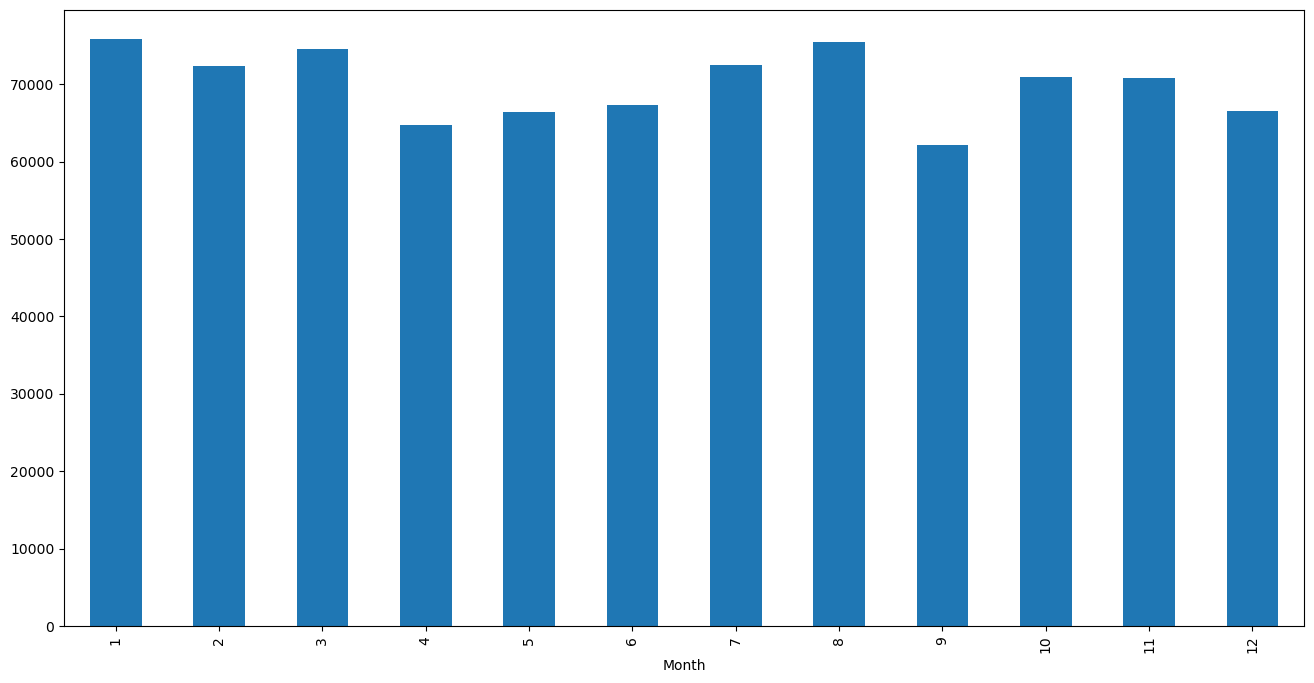

In [72]:
SF_DATA["Month"].groupby(SF_DATA["Month"]).count().plot(figsize=(16,8),kind="bar")

In [73]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district,Month
0,2023-03-13,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
1,2023-03-01,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN,3
2,2023-03-13,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
3,2023-03-13,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
4,2023-03-14,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
...,...,...,...,...,...,...,...,...,...,...
839737,2023-03-22,2023-03-22T00:00:00.000,13:30,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9,3
839738,2023-03-22,2023-03-22T00:00:00.000,00:13,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2,3
839739,2023-03-21,2023-03-21T00:00:00.000,21:19,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11,3
839740,2023-03-22,2023-03-22T00:00:00.000,15:28,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3,3


In [74]:
SF_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839742 entries, 0 to 839741
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   incident_datetime     839742 non-null  datetime64[ns]
 1   incident_date         839742 non-null  object        
 2   incident_time         839742 non-null  object        
 3   incident_year         839742 non-null  object        
 4   incident_day_of_week  839742 non-null  object        
 5   report_datetime       839742 non-null  object        
 6   incident_category     838963 non-null  object        
 7   incident_subcategory  838963 non-null  object        
 8   supervisor_district   792782 non-null  object        
 9   Month                 839742 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 60.9+ MB
